# Temporal Convolutional Network

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/My Drive/Pump Data/

/content/gdrive/My Drive/Pump Data


In [4]:
!ls

data


In [1]:
!pip install matplotlib==3.1.3
!pip install darts

     |████████████████████████████████| 13.1 MB 5.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 286 kB 5.2 MB/s 
     |████████████████████████████████| 38.2 MB 1.2 MB/s 
     |████████████████████████████████| 11.2 MB 22.9 MB/s 
     |████████████████████████████████| 9.8 MB 18.4 MB/s 
     |████████████████████████████████| 177 kB 73.4 MB/s 
     |████████████████████████████████| 2.0 MB 58.0 MB/s 
     |████████████████████████████████| 62 kB 832 kB/s 
     |████████████████████████████████| 1.4 MB 55.1 MB/s 
     |████████████████████████████████| 65 kB 4.5 MB/s 
     |████████████████████████████████| 790 kB 53.2 MB/s 
     |████████████████████████████████| 11.3 MB 129 kB/s 
     |████████████████████████████████| 155 kB 61.2 MB/s 
     |████████████████████████████████| 374 kB 46.5 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 214 kB 49.2 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=2e520e609d3eb64e04e89c1f16cbdcf5e3ef7dd684089c

In [12]:
EPOCH = 100


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta, TCNModel
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf, plot_hist
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


FC_N = 12               # forecast periods
FC_STRIDE = 10
FC_START = '2019-07-25 00:00:00'   # period at which to split training and validation dataset
DROP = 0.1
LEARN = 0.001

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

In [15]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper


In [16]:
data_address = 'data'
training = pd.read_csv(data_address +'/cfp_dataset_v1.csv', index_col=False)
training.drop(['Unnamed: 0', 'MIDUPT1138P2300058', 'SHORTUPT1138P2300058', 'LONGUPT1138P2300058', 'DMIDT1138P2300058',  'DLONGT1138P2300058', 'UNIXDT', 'UUID'], axis=1, inplace=True)

In [17]:
training.columns

Index(['WELL_ID', 'DT', 'T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399',
       'DSHORTT1138P2300058'],
      dtype='object')

In [18]:
only_1_bad = training[training['WELL_ID'] == 226003316].copy()


In [19]:
only_1_bad.DT

9990     2019-07-31 23:55:00
9991     2019-07-31 23:50:00
9992     2019-07-31 23:45:00
9993     2019-07-31 23:40:00
9994     2019-07-31 23:35:00
                ...         
19972    2019-06-27 07:00:00
19973    2019-06-27 06:55:00
19974    2019-06-27 06:50:00
19975    2019-06-27 06:45:00
19976    2019-06-27 06:40:00
Name: DT, Length: 9987, dtype: object

## подготовим данные для всех насосов

In [20]:
from sklearn.preprocessing import LabelBinarizer

pump_encoder = LabelBinarizer()
transformed = pump_encoder.fit_transform(training.WELL_ID)
ohe_df = pd.DataFrame(transformed)
ohe_df.columns = pump_encoder.classes_
training_oh = pd.concat([training, ohe_df], axis=1).drop(['WELL_ID'], axis=1)
training_oh

,DT,T1138P6000096,T1138P6000315,DMIDT1138P4000064,DSHORTT1138P4000064,DLONGT1138P4000064,DMIDT1138P2600012,DSHORTT1138P2600012,DLONGT1138P2600012,DMIDT1205P2300000,DSHORTT1205P2300000,DLONGT1205P2300000,T1205P2300000,T1138P4000064,T1138P2600012,T1138P600050,T1013P500399,DSHORTT1138P2300058,226000188,226000198,226000297,226001846,226001947,226002142,226002148,226002307,226002416,226002603,226002627,226002861,226002998,226003074,226003080,226003316,226003330
0,2019-07-31 23:55:00,300,0,-2.150755,0.0,-2.290611,-0.279070,0.0,-0.313752,-0.001102,0.000587,-0.000245,1.168133,70,19.6,0.759,NaN,-0.1344,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2019-07-31 23:50:00,0,0,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.167644,70,19.6,0.761,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2019-07-31 23:45:00,0,28500,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.161290,0,0.0,0.000,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2019-07-31 23:40:00,0,28200,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.160802,0,0.0,0.000,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2019-07-31 23:35:00,0,27900,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.162268,0,0.0,0.000,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160257,2019-06-27 07:00:00,0,14400,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,0.001927,0.000000,0.000129,1.642718,0,0.0,0.000,NaN,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160258,2019-06-27 06:55:00,0,14100,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,0.001927,0.000000,0.000129,1.648583,0,0.0,0.000,NaN,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160259,2019-06-27 06:50:00,0,13800,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,0.001927,0.000000,0.000129,1.650049,0,0.0,0.000,NaN,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160260,2019-06-27 06:45:00,0,13500,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,0.001927,0.000000,0.000129,1.681818,0,0.0,0.000,NaN,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


реализовать нарезку на train-test


In [21]:
def get_pump_names(df):
  """
  вытаскиваем set из колонок по df, который подали
  """
  values = df.columns
  return set(values)


def split_df_by_pumps(input_df, ohe_df):
  """
  input_df: дф, в котором есть колонки onehot с насовами
  ohe_df: дф onehot для насосов
  выдает 17 штук train set
  """

  pump_ids = get_pump_names(ohe_df)
  df_list = list()

  for pump in pump_ids:
    df_list.append(input_df[input_df[pump] == 1])

  return df_list



реализовать нарезку на файлы по названию насосов

find when to split?

In [22]:
only_1_bad['DT'] = pd.to_datetime(only_1_bad['DT'] )

print(only_1_bad.DT.min()-
      only_1_bad.DT.max())

only_1_bad.DT.min() + (only_1_bad.DT.max() - only_1_bad.DT.min()) * 0.8

-35 days +06:45:00


Timestamp('2019-07-25 01:16:00')

In [23]:
series = TimeSeries.from_dataframe(only_1_bad, 'DT', fill_missing_dates=True, freq=None)


In [24]:
scaler = Scaler()
ts = scaler.fit_transform(series)  # scale the whole time series not caring about train/val split...
filler = MissingValuesFiller()
ts = filler.transform(ts, method='quadratic')
target = ts['DSHORTT1138P2300058']
# Create training and validation sets:
train_target, val_target = target.split_after(pd.Timestamp(FC_START))

covariates = ts[['WELL_ID', 'T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399']]

train_cov, val_cov = covariates.split_after(pd.Timestamp(FC_START))
train_1cov, val_1cov = covariates['T1138P600050'].split_after(pd.Timestamp(FC_START))

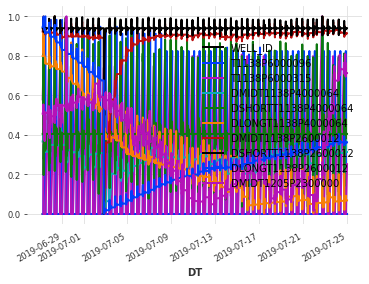

In [25]:
train_cov.plot()

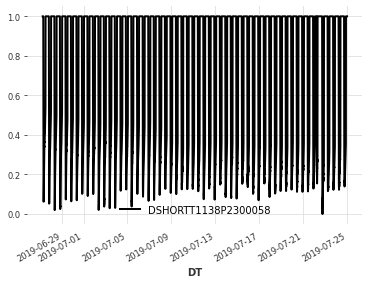

In [26]:
train_target.plot()

In [27]:
train_1cov.freq

<5 * Minutes>

In [28]:
train_1cov.pd_dataframe()

component,T1138P600050
DT,
2019-06-27 06:40:00,0.0
2019-06-27 06:45:00,0.0
2019-06-27 06:50:00,0.0
2019-06-27 06:55:00,0.0
2019-06-27 07:00:00,0.0
...,...
2019-07-24 23:40:00,0.0
2019-07-24 23:45:00,0.0
2019-07-24 23:50:00,0.0


In [29]:
train_target.describe()


component,DSHORTT1138P2300058
count,7985.000000
mean,0.748431
std,0.356740
min,0.000000
25%,0.322829
50%,1.000000
75%,1.000000
max,1.000000


In [30]:
train_target

<TimeSeries (DataArray) (DT: 7985, component: 1, sample: 1)>
array([[[1.]],

       [[1.]],

       [[1.]],

       ...,

       [[1.]],

       [[1.]],

       [[1.]]])
Coordinates:
  * DT         (DT) datetime64[ns] 2019-06-27T06:40:00 ... 2019-07-25
  * component  (component) object 'DSHORTT1138P2300058'
Dimensions without coordinates: sample

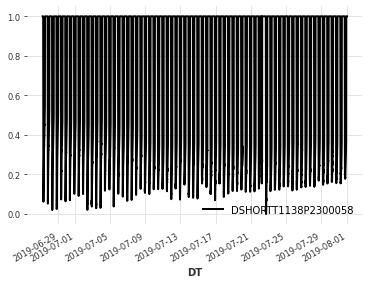

In [31]:
target.plot()

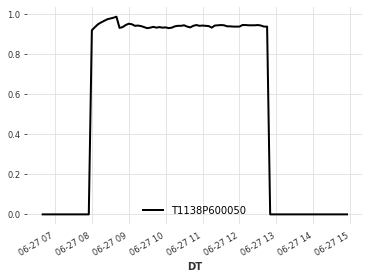

In [32]:
train_1cov[:100].plot()

In [33]:
# analyze its seasonality

is_seasonal, periodicity = check_seasonality(target, max_lag=1000)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (5*minutes)":f'{periodicity:.1f}', 
    "periodicity (hours)":f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (5*minutes) : 144.0
periodicity (hours) : 12.0


In [34]:
import statsmodels.api as sm

<AxesSubplot:xlabel='DT'>

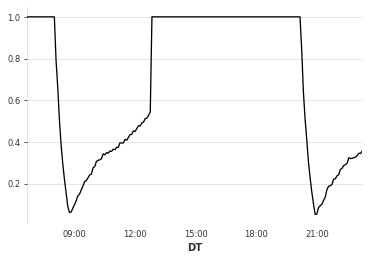

In [35]:
target.pd_dataframe().DSHORTT1138P2300058[:200].plot()

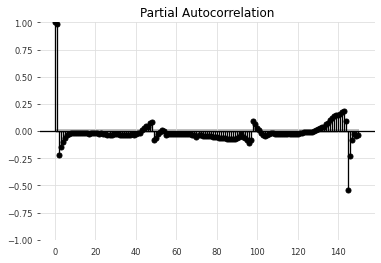

In [36]:
sm.graphics.tsa.plot_pacf(target.pd_dataframe().DSHORTT1138P2300058, lags=150)
plt.show()

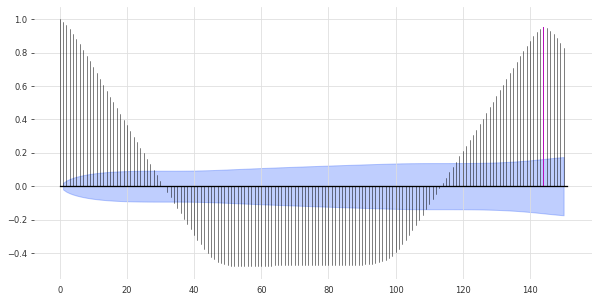

In [37]:
plot_acf(target, periodicity, max_lag=150)


In [38]:
target.describe()

component,DSHORTT1138P2300058
count,10000.000000
mean,0.750620
std,0.355972
min,0.000000
25%,0.319466
50%,1.000000
75%,1.000000
max,1.000000


In [39]:
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape, mae


# lets do a simple one

In [40]:
one_var = covariates['T1205P2300000'].copy()

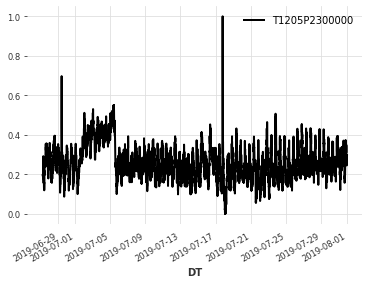

In [41]:
one_var.plot()

In [42]:
train_cov1, val_cov1 = one_var.split_after(pd.Timestamp('2019-07-25 00:00:00'))

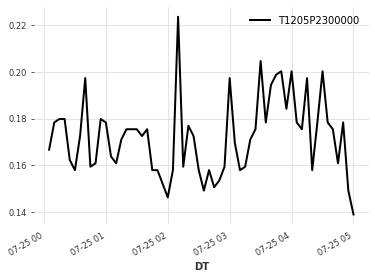

In [43]:
val_cov1[:60].plot()

In [44]:
val_cov1.time_index

DatetimeIndex(['2019-07-25 00:05:00', '2019-07-25 00:10:00',
               '2019-07-25 00:15:00', '2019-07-25 00:20:00',
               '2019-07-25 00:25:00', '2019-07-25 00:30:00',
               '2019-07-25 00:35:00', '2019-07-25 00:40:00',
               '2019-07-25 00:45:00', '2019-07-25 00:50:00',
               ...
               '2019-07-31 23:10:00', '2019-07-31 23:15:00',
               '2019-07-31 23:20:00', '2019-07-31 23:25:00',
               '2019-07-31 23:30:00', '2019-07-31 23:35:00',
               '2019-07-31 23:40:00', '2019-07-31 23:45:00',
               '2019-07-31 23:50:00', '2019-07-31 23:55:00'],
              dtype='datetime64[ns]', name='DT', length=2015, freq='5T')

In [45]:
model_1var = TCNModel(
    input_chunk_length=24,
    output_chunk_length=2,
    n_epochs=EPOCH,
    dropout=0.01,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

In [46]:
model_1var.fit(series=train_target,
              past_covariates=train_cov1,
              val_series=val_target,
              val_past_covariates=val_cov1,
              verbose=True)

 20%|██        | 1/5 [00:05<00:23,  5.91s/it]

100%|██████████| 5/5 [00:25<00:00,  5.00s/it]


In [47]:
backtest_1var = model_1var.historical_forecasts(series=val_target,
                                                past_covariates=val_cov1, start=0.1,
                                            retrain=False,
                                            verbose=True)


100%|██████████| 1814/1814 [00:18<00:00, 96.59it/s]


In [48]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


In [49]:
val_target_inters = val_target.slice_intersect(backtest_1var)

MAPE = 0.07%
MAE = 0.04
smape = 0.07%
R2 = 0.93%


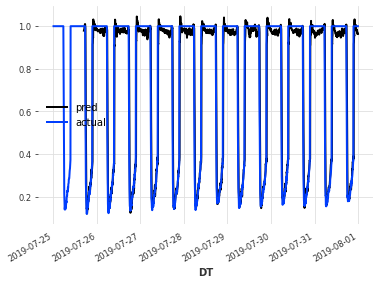

In [50]:
backtest_1var.plot(label='pred')
val_target.plot(label='actual')
plt.legend();
print('MAPE = {:.2f}%'.format(mean_absolute_percentage_error(val_target_inters.values(), backtest_1var.values())))
print('MAE = {:.2f}'.format(mae(val_target_inters, backtest_1var)))
print('smape = {:.2f}%'.format(smape(val_target_inters.values(), backtest_1var.values())))
print('R2 = {:.2f}%'.format(r2_score(val_target_inters.values(), backtest_1var.values())))


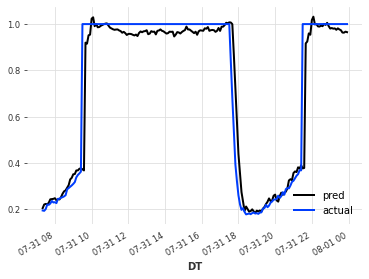

In [51]:
backtest_1var[-200:].plot(label='pred')
val_target[-200:].plot(label='actual')


## do with all covariates for 1 pump

In [52]:
model_1pump = TCNModel(
    input_chunk_length=144,
    output_chunk_length=1,
    n_epochs=EPOCH,
    dropout=0.01,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

In [53]:
model_1pump.fit(series=train_target,
              past_covariates=train_cov,
              val_series=val_target,
              val_past_covariates=val_cov,
              verbose=True)

 20%|██        | 1/5 [00:09<00:37,  9.37s/it]

100%|██████████| 5/5 [00:41<00:00,  8.30s/it]


In [54]:
backtest_1pump = model_1pump.historical_forecasts(series=val_target,
                                                past_covariates=val_cov, start=0.1,
                                            retrain=False,
                                            verbose=True)


100%|██████████| 1814/1814 [00:19<00:00, 92.54it/s]


In [55]:
val_1pumptarget_inters = val_target.slice_intersect(backtest_1pump)

MAPE = 0.05%
MAE = 0.02
smape = 0.05%
R2 = 0.98%


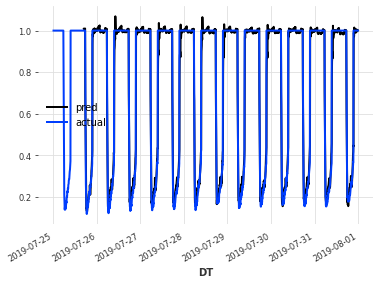

In [56]:
backtest_1pump.plot(label='pred')
val_target.plot(label='actual')
plt.legend();
print('MAPE = {:.2f}%'.format(mean_absolute_percentage_error(val_1pumptarget_inters.values(), backtest_1pump.values())))
print('MAE = {:.2f}'.format(mae(val_1pumptarget_inters, backtest_1pump)))
print('smape = {:.2f}%'.format(smape(val_1pumptarget_inters.values(), backtest_1pump.values())))
print('R2 = {:.2f}%'.format(r2_score(val_1pumptarget_inters.values(), backtest_1pump.values())))


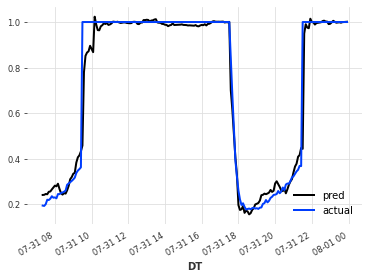

In [57]:
backtest_1pump[-200:].plot(label='pred')
val_target[-200:].plot(label='actual')

## сделаем теперь обучение на множестве временных рядов

In [58]:
all_pumps_df = split_df_by_pumps(training_oh, ohe_df)

In [59]:
all_pumps_df[0].head()

,DT,T1138P6000096,T1138P6000315,DMIDT1138P4000064,DSHORTT1138P4000064,DLONGT1138P4000064,DMIDT1138P2600012,DSHORTT1138P2600012,DLONGT1138P2600012,DMIDT1205P2300000,DSHORTT1205P2300000,DLONGT1205P2300000,T1205P2300000,T1138P4000064,T1138P2600012,T1138P600050,T1013P500399,DSHORTT1138P2300058,226000188,226000198,226000297,226001846,226001947,226002142,226002148,226002307,226002416,226002603,226002627,226002861,226002998,226003074,226003080,226003316,226003330
29577,2019-07-31 23:55:00,0,18600,-3.186951,0.0,-3.386913,-0.440678,0.0,-0.432121,-0.004463,0.0,0.001861,1.053275,0,0.0,0.0,3.82873,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
29578,2019-07-31 23:50:00,0,18300,-3.186951,0.0,-3.386913,-0.440678,0.0,-0.432121,-0.004463,0.0,0.001861,1.053763,0,0.0,0.0,3.82873,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
29579,2019-07-31 23:45:00,0,18000,-3.186951,0.0,-3.386913,-0.440678,0.0,-0.432121,-0.004463,0.0,0.001861,1.057185,0,0.0,0.0,3.82873,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
29580,2019-07-31 23:40:00,0,17700,-3.186951,0.0,-3.386913,-0.440678,0.0,-0.432121,-0.004463,0.0,0.001861,1.057185,0,0.0,0.0,3.82873,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
29581,2019-07-31 23:35:00,0,17400,-3.186951,0.0,-3.386913,-0.440678,0.0,-0.432121,-0.004463,0.0,0.001861,1.061095,0,0.0,0.0,3.82873,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [60]:
FC_START

'2019-07-25 00:00:00'

In [61]:
def get_one_pump_train_date(inp_df):
  onehot_series_0 = TimeSeries.from_dataframe(inp_df, 'DT', fill_missing_dates=True, freq='5T')

  scaler = Scaler()
  ts = scaler.fit_transform(onehot_series_0)  # scale the whole time series not caring about train/val split...
  filler = MissingValuesFiller()
  ts = filler.transform(ts, method='linear')
  target = ts['DSHORTT1138P2300058']
  # Create training and validation sets:
  train_target, val_target = target.split_after(pd.Timestamp(FC_START))

  covariates = ts[['T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
        'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
        'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
        'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
        'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399']]

  train_cov, val_cov = covariates.split_after(pd.Timestamp(FC_START))
  print(len(train_cov), len(train_target), len(val_cov), len(val_target))
  return train_cov, train_target, val_cov, val_target

def get_all_pump_training_date(df_all_pumps):
  train_cov_all, train_target_all, val_cov_all, val_target_all = [], [], [], []
  for pump_df in df_all_pumps:
    iter_train, iter_target, iter_val, iter_val_target = get_one_pump_train_date(pump_df)
    train_cov_all.append(iter_train)
    train_target_all.append(iter_target)
    val_cov_all.append(iter_val)
    val_target_all.append(iter_val_target)
  return train_cov_all, train_target_all, val_cov_all, val_target_all


In [62]:
train_cov_v3, train_target_v3, val_cov_v3, val_target_v3= get_all_pump_training_date(all_pumps_df)

7985 7985 2015 2015
7985 7985 2015 2015
1165 1165 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015


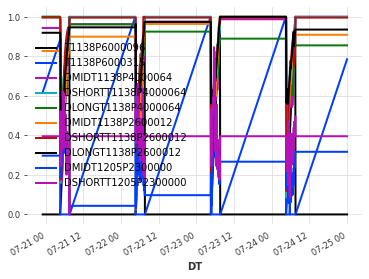

In [63]:
train_cov_v3[2].plot()

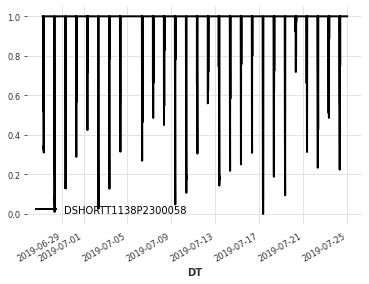

In [64]:
train_target_v3[1].plot()

In [65]:
model_all_pumps = TCNModel(
    input_chunk_length=144,
    output_chunk_length=1,
    n_epochs=EPOCH,
    dropout=0.01,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

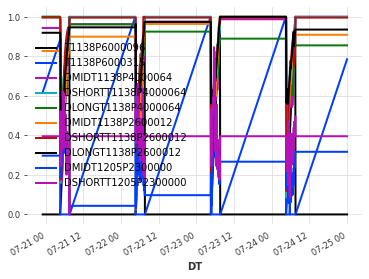

In [66]:
train_cov_v3[2].plot()

In [67]:
model_all_pumps.fit(series=train_target_v3,
              past_covariates=train_cov_v3,
              val_series=val_target_v3,
              val_past_covariates=val_cov_v3,
              verbose=True)

 20%|██        | 1/5 [02:35<10:20, 155.00s/it]

100%|██████████| 5/5 [11:32<00:00, 138.58s/it]


In [68]:
model_all_pumps.save_model('allpumps_tcn_v1.pth.tar')

In [78]:
backtest_model_all_pumps = model_all_pumps.historical_forecasts(series=val_target_v3[0],
                                                past_covariates=val_cov_v3[0], start=0.1,
                                            retrain=False,
                                            verbose=True)


100%|██████████| 1814/1814 [00:19<00:00, 94.57it/s]


In [79]:
backtest_v3 = val_target_v3[0]
val_v3pumptarget_inters = backtest_v3.slice_intersect(backtest_model_all_pumps)


MAPE = 1.00%
MAE = 0.01
smape = 1.00%
R2 = 98.73%


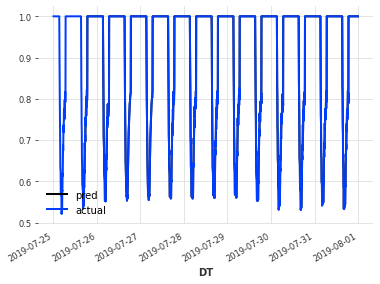

In [86]:
val_v3pumptarget_inters.plot(label='pred')
val_target_v3[0].plot(label='actual')
plt.legend();
print('MAPE = {:.2f}%'.format(mean_absolute_percentage_error(val_v3pumptarget_inters.values(), backtest_model_all_pumps.values())*100))
print('MAE = {:.2f}'.format(mae(val_v3pumptarget_inters, backtest_model_all_pumps)))
print('smape = {:.2f}%'.format(smape(val_v3pumptarget_inters.values(), backtest_model_all_pumps.values())*100))
print('R2 = {:.2f}%'.format(r2_score(val_v3pumptarget_inters.values(), backtest_model_all_pumps.values())*100))


сделаем процедуру для запуска по всем насосам валидации

In [95]:
get_pump_names(ohe_df)


{226000188,
 226000198,
 226000297,
 226001846,
 226001947,
 226002142,
 226002148,
 226002307,
 226002416,
 226002603,
 226002627,
 226002861,
 226002998,
 226003074,
 226003080,
 226003316,
 226003330}

In [163]:
def score_model_darts(model, validation_target, validation_cov, pump_names):
    results = pd.DataFrame(columns=['mape', 'smape', 'mae', 'r2_value'])
    pump_num = 0
    true_values = []
    predict_values = []
    for key in pump_names:
        backtest_model_all_pumps_iter = model_all_pumps.historical_forecasts(
            series=validation_target[pump_num],
            past_covariates=validation_cov[pump_num],
            start=0.1,
            retrain=False,
            verbose=True)

        backtest_v3 = validation_target[pump_num]
        val_v3pumptarget_inters = backtest_v3.slice_intersect(backtest_model_all_pumps_iter)

        

        y_true = val_v3pumptarget_inters.values()
        y_pred = backtest_model_all_pumps_iter.values()

        true_values.append(y_true)
        predict_values.append(y_pred)


        mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
        smape_v = smape(y_true, y_pred)
        mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
        r2_value = r2_score(y_true=y_true, y_pred=y_pred)

        this_key_df = pd.DataFrame({'mape': mape, 'smape': smape_v, 'mae': mae, 'r2_value': r2_value}, index=[key])
        results = results.append(this_key_df)

        val_v3pumptarget_inters[-100:].plot(label='pred')
        backtest_model_all_pumps_iter[-100:].plot(label='actual')
        plt.show()
        val_v3pumptarget_inters[:1000].plot(label='pred_first1k')
        backtest_model_all_pumps_iter[:1000].plot(label='actual_first1k')
        plt.show()
        pump_num += 1

    true_values = np.concatenate(true_values)
    predict_values = np.concatenate(predict_values)
    return results, true_values, predict_values


100%|██████████| 1814/1814 [00:21<00:00, 85.18it/s]


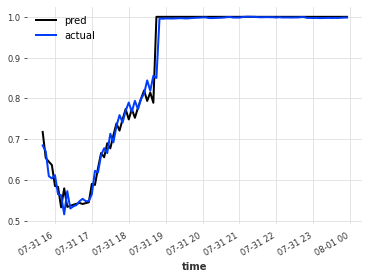

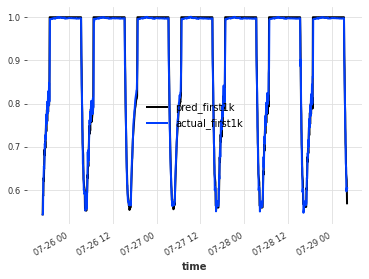

100%|██████████| 1814/1814 [00:20<00:00, 87.64it/s]


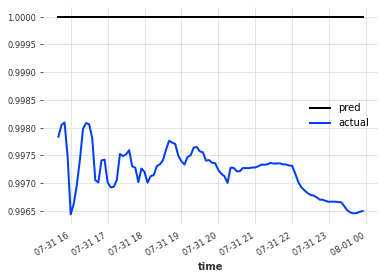

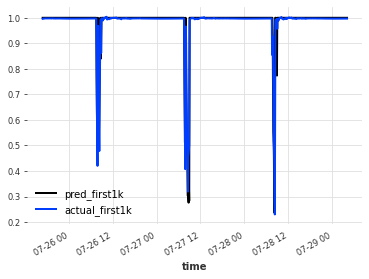

100%|██████████| 1814/1814 [00:20<00:00, 89.12it/s]


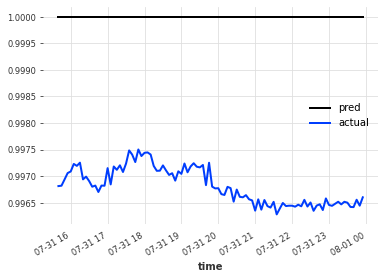

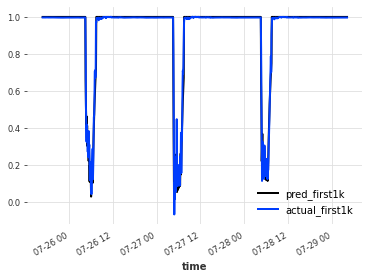

100%|██████████| 1814/1814 [00:20<00:00, 87.71it/s]


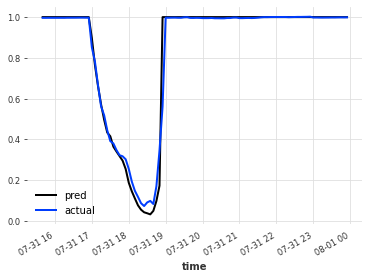

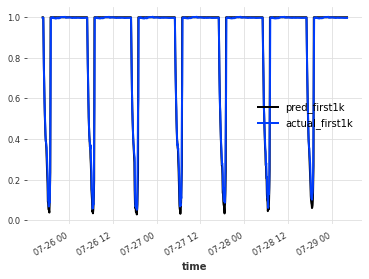

100%|██████████| 1814/1814 [00:20<00:00, 87.63it/s]


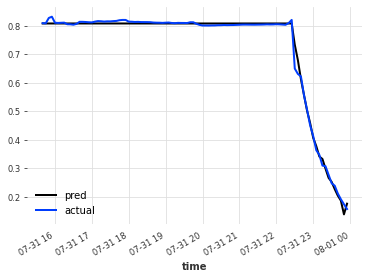

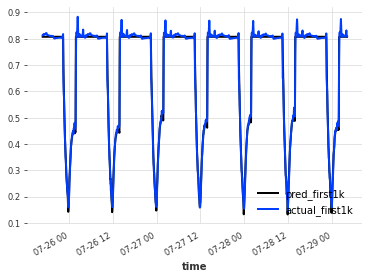

100%|██████████| 1814/1814 [00:20<00:00, 87.56it/s]


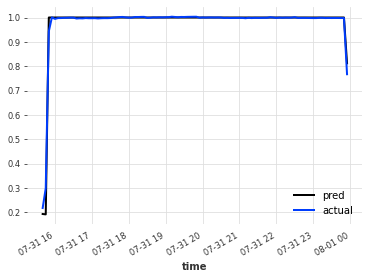

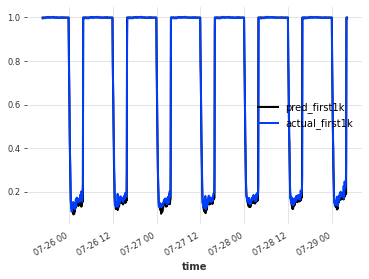

100%|██████████| 1814/1814 [00:20<00:00, 86.47it/s]


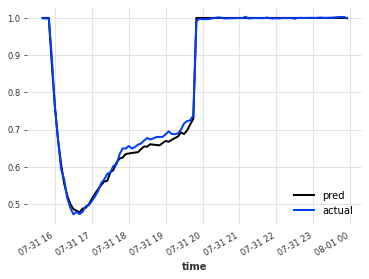

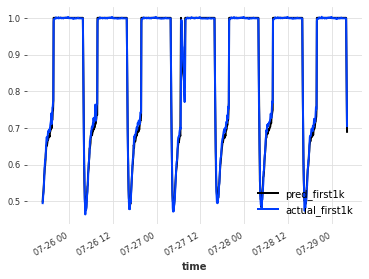

100%|██████████| 1814/1814 [00:21<00:00, 85.58it/s]


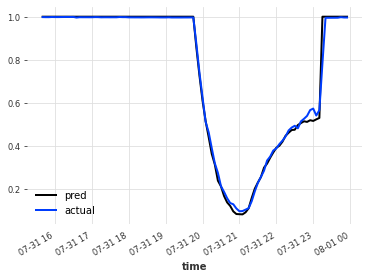

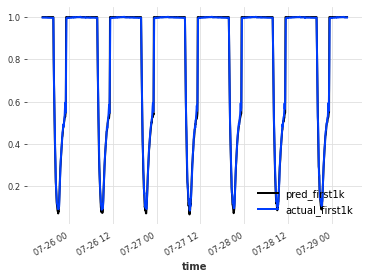

100%|██████████| 1814/1814 [00:21<00:00, 84.78it/s]


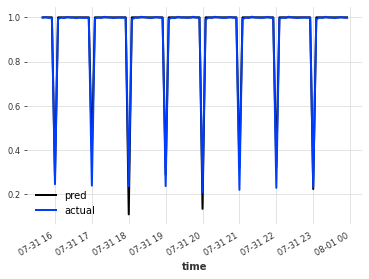

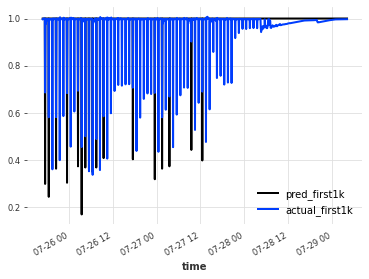

100%|██████████| 1814/1814 [00:21<00:00, 84.86it/s]


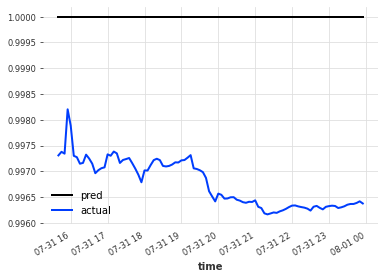

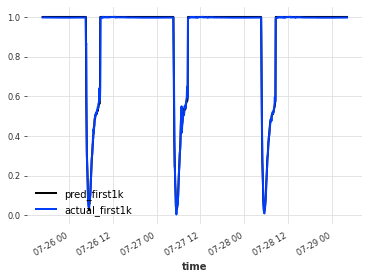

100%|██████████| 1814/1814 [00:21<00:00, 85.23it/s]


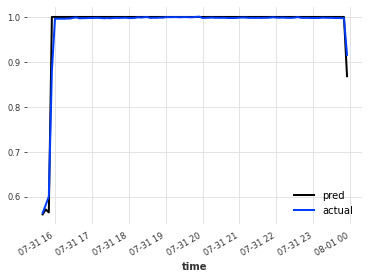

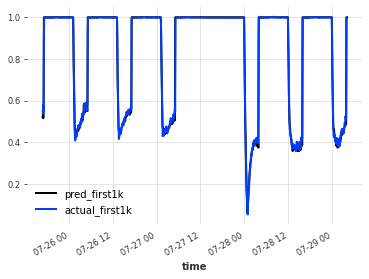

100%|██████████| 1814/1814 [00:22<00:00, 81.62it/s]


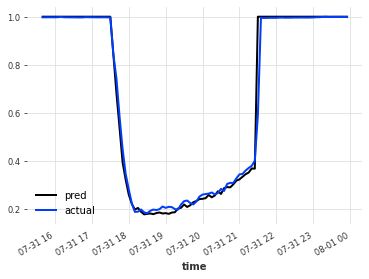

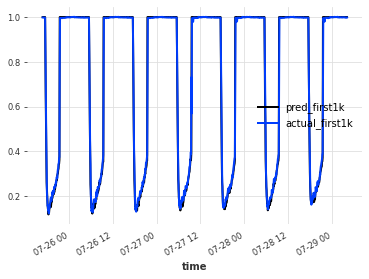

100%|██████████| 1814/1814 [00:22<00:00, 82.37it/s]


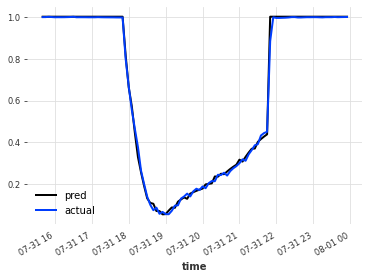

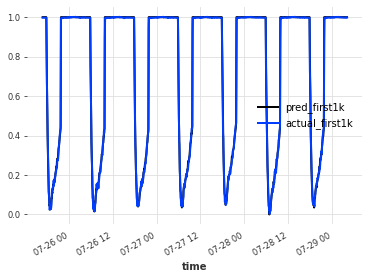

100%|██████████| 1814/1814 [00:21<00:00, 83.77it/s]


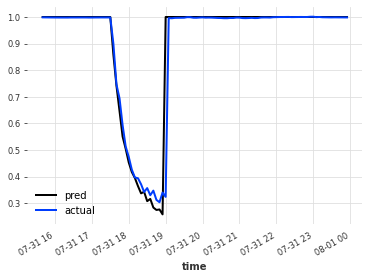

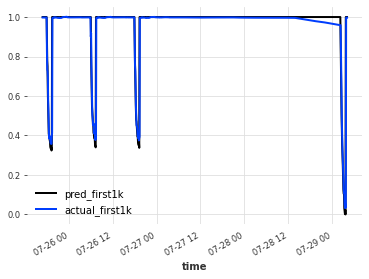

100%|██████████| 1814/1814 [00:22<00:00, 81.51it/s]


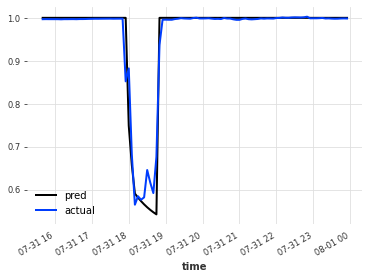

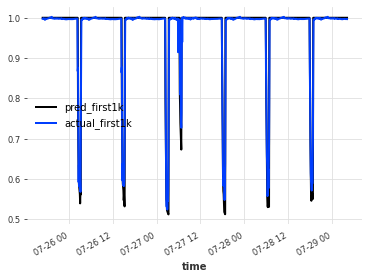

100%|██████████| 1814/1814 [00:21<00:00, 84.74it/s]


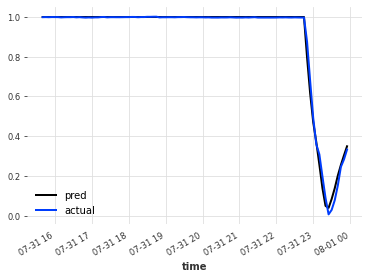

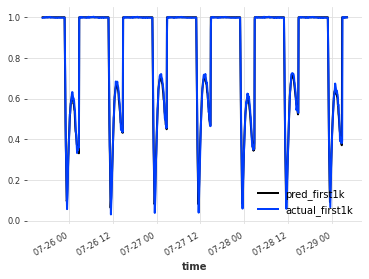

100%|██████████| 1814/1814 [00:22<00:00, 81.18it/s]


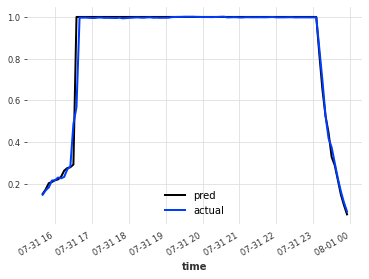

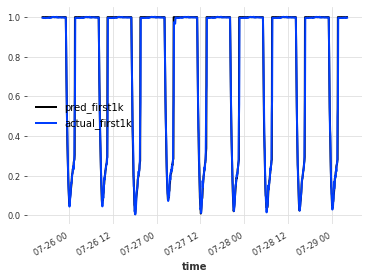

,mape,smape,mae,r2_value
226003074,9.986479e-03,0.010006,0.007719,0.987269
226002307,2.034585e-02,0.016809,0.009629,0.880216
226002148,3.572339e+11,0.047155,0.012813,0.975616
226002627,5.978517e-02,0.044457,0.011446,0.977184
226000198,1.812970e-02,0.017985,0.009260,0.993799
226003330,4.294052e-02,0.039966,0.009838,0.991404
226003080,7.806600e-03,0.007775,0.005394,0.996442
226000297,2.457130e-02,0.023159,0.008109,0.995050
226002603,5.694109e+11,0.038192,0.021506,0.713577
226002861,1.820135e-02,0.018108,0.005439,0.995904


In [164]:
results_for_17_test, true_17_test, predict_17 = score_model_darts(model=model_all_pumps, 
                        validation_target=val_target_v3,
                        validation_cov=val_cov_v3,
                        pump_names=get_pump_names(ohe_df))
results_for_17_test

In [111]:
results_for_17_test.to_csv('test_results.csv') 

In [112]:
results_for_17_test.mean()

mape        6.687340e+10
smape       2.581895e-02
mae         9.545908e-03
r2_value    9.604678e-01
dtype: float64

In [169]:
test_tcn = {'test':{'true':true_17_test, 
                      'prediction':predict_17}}

In [170]:
from utils import score_model

In [171]:
test_results = score_model(test_tcn)
test_results

,mape,smape,mae,r2_value
test,6.687340e+10,0.025819,0.009546,0.983018


loading validation dataset

In [200]:

def get_one_pump_ext_val(inp_df):
  onehot_series_0 = TimeSeries.from_dataframe(inp_df, 'DT', fill_missing_dates=True, freq='5T')

  scaler = Scaler()
  ts = scaler.fit_transform(onehot_series_0)  # scale the whole time series not caring about train/val split...
  filler = MissingValuesFiller()
  ts = filler.transform(ts, method='linear')
  target = ts['DSHORTT1138P2300058']
  # Create training and validation sets:

  covariates = ts[['T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
        'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
        'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
        'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
        'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399']]

  print(len(covariates), len(target))
  return covariates, target

def get_all_pump_ext_val(df_all_pumps):
  val_cov_all, val_target_all = [], []
  for pump_df in df_all_pumps:
    iter_val, iter_val_target = get_one_pump_ext_val(pump_df)
    val_cov_all.append(iter_val)
    val_target_all.append(iter_val_target)
  return val_cov_all, val_target_all


def read_valid(link, encoder):

    data = pd.read_csv(link, index_col=False)
    data.drop(['Unnamed: 0',
     'MIDUPT1138P2300058',
     'SHORTUPT1138P2300058',
     'LONGUPT1138P2300058',
     'DMIDT1138P2300058',
     'DLONGT1138P2300058',
     'UNIXDT', 'UUID'
     ], axis=1, inplace=True)
    data = data.fillna(0)
    
    transformed = encoder.transform(data.WELL_ID)
    ohe_df = pd.DataFrame(transformed)
    ohe_df.columns = encoder.classes_
    df_oh = pd.concat([data, ohe_df], axis=1).drop(['WELL_ID'], axis=1)

    pump_ids = set(data.WELL_ID.unique())


    df_list = list()

    for pump in pump_ids:
        df_list.append(df_oh[df_oh[pump] == 1])

    val_cov, val_target = get_all_pump_ext_val(df_list)

    return val_target, val_cov, pump_ids

In [201]:
valid1 = 'data/cfp_dataset_v1_valid1.csv'
valid2 = 'data/cfp_dataset_v1_valid2.csv'

In [202]:
val_target1, val_cov1, val1_pumps  = read_valid(valid1, pump_encoder)
val_target2, val_cov2, val2_pumps  = read_valid(valid2, pump_encoder)

1667 1667
963 963
1667 1667
1667 1667
1667 1667
963 963
1667 1667
1667 1667
1667 1667
1667 1667
1667 1667
1263 1263
1667 1667
1667 1667
1667 1667
1667 1667
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334


## запустим более подробно с графиками

In [245]:
def validate_model(model, validation_target, validation_cov):
    results = pd.DataFrame(columns=['mape', 'smape', 'mae', 'r2_value'])
    true_values = []
    predict_values = []
    for part in range(len(validation_target)):
        print(len(validation_target[part]), len(validation_cov[part]))
        backtest_model_all_pumps_iter = model.historical_forecasts(
            series=validation_target[part],
            past_covariates=validation_cov[part],
            start=0.4,
            retrain=False,
            verbose=True)

        backtest_v3 = validation_target[part]
        val_v3pumptarget_inters = backtest_v3.slice_intersect(backtest_model_all_pumps_iter)

        

        y_true = val_v3pumptarget_inters.values()
        y_pred = backtest_model_all_pumps_iter.values()

        true_values.append(y_true)
        predict_values.append(y_pred)


        mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
        smape_v = smape(y_true, y_pred)
        mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
        r2_value = r2_score(y_true=y_true, y_pred=y_pred)

        this_key_df = pd.DataFrame({'mape': mape, 'smape': smape_v, 'mae': mae, 'r2_value': r2_value}, index=[part])
        results = results.append(this_key_df)

        val_v3pumptarget_inters[-100:].plot(label='pred')
        backtest_model_all_pumps_iter[-100:].plot(label='actual')
        plt.show()
        val_v3pumptarget_inters[:1000].plot(label='pred_first1k')
        backtest_model_all_pumps_iter[:1000].plot(label='actual_first1k')
        plt.show()

    true_values = np.concatenate(true_values)
    predict_values = np.concatenate(predict_values)
    return results, true_values, predict_values


1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 93.04it/s]


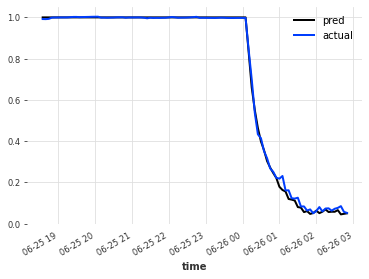

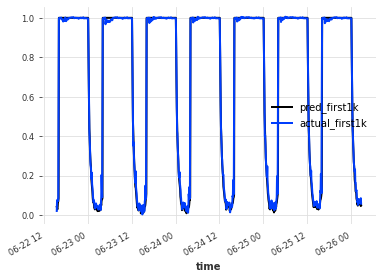

963 963


100%|██████████| 579/579 [00:06<00:00, 91.47it/s]


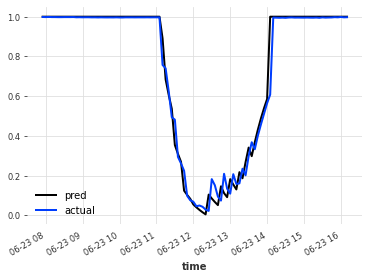

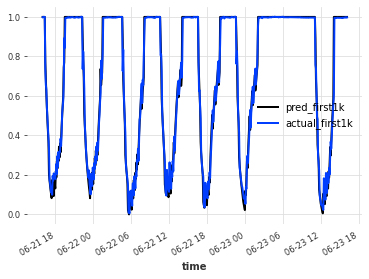

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 89.25it/s]


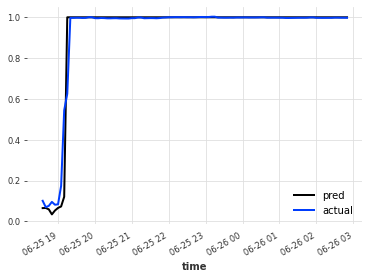

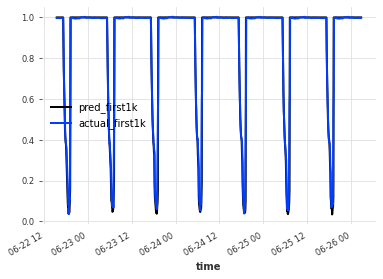

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 89.26it/s]


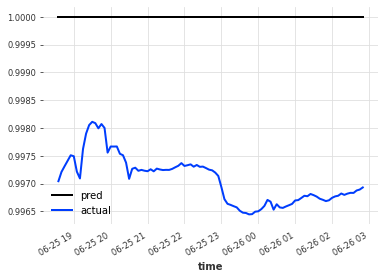

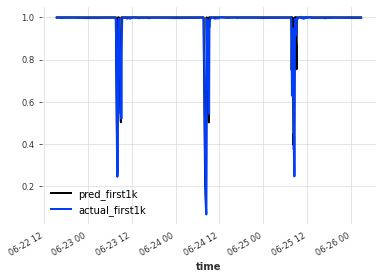

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 89.25it/s]


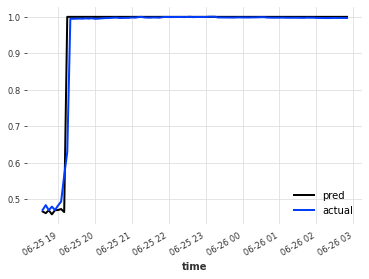

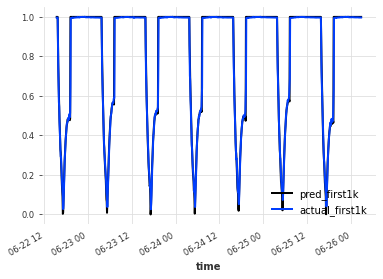

963 963


100%|██████████| 579/579 [00:06<00:00, 88.20it/s]


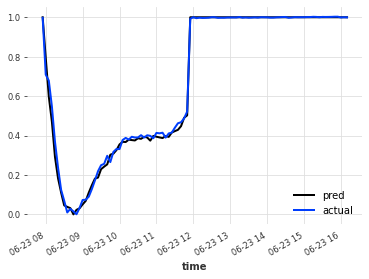

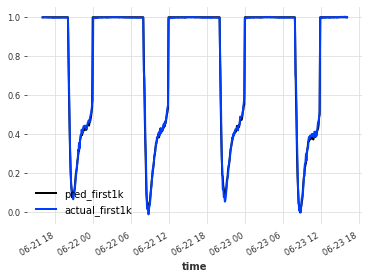

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 87.97it/s]


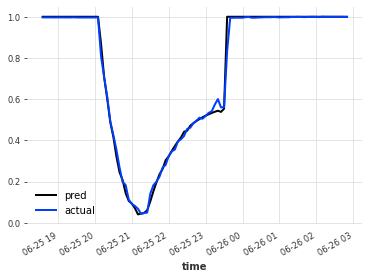

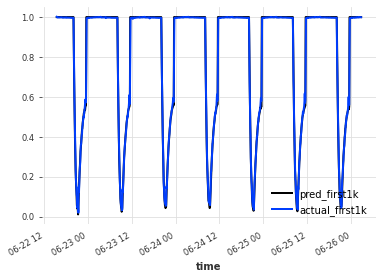

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 88.58it/s]


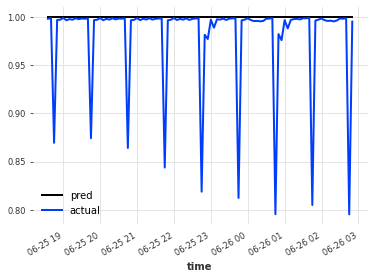

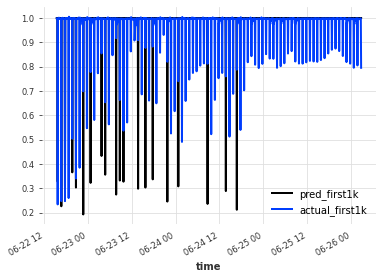

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 85.61it/s]


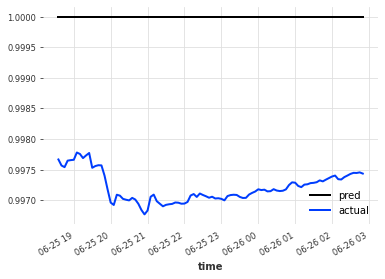

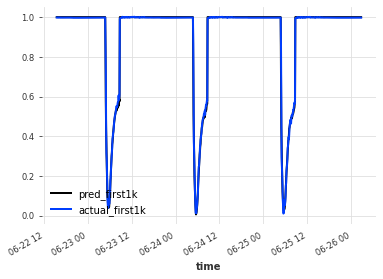

1667 1667


100%|██████████| 1001/1001 [00:12<00:00, 83.05it/s]


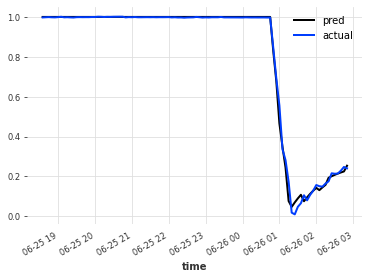

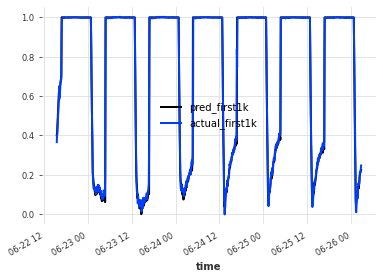

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 84.97it/s]


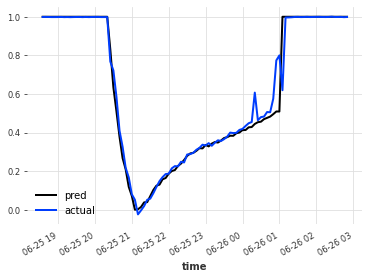

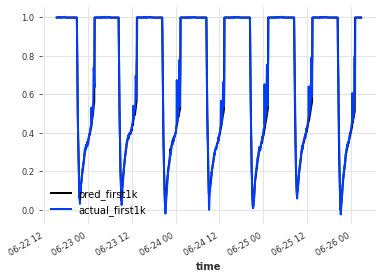

1263 1263


100%|██████████| 759/759 [00:08<00:00, 86.29it/s]


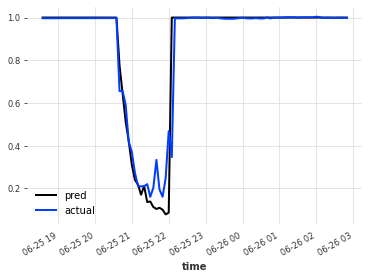

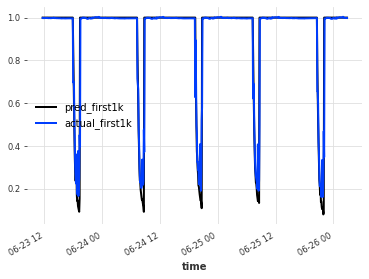

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 85.52it/s]


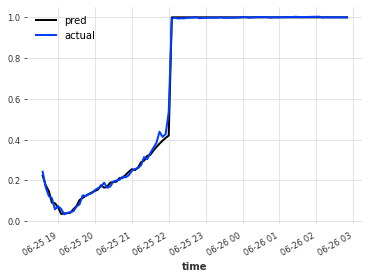

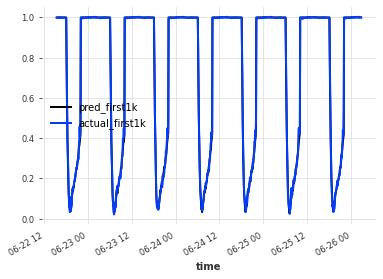

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 86.11it/s]


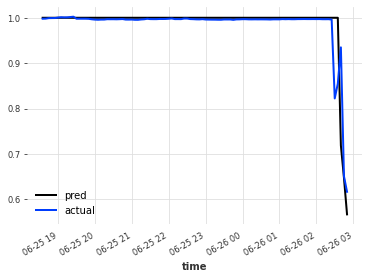

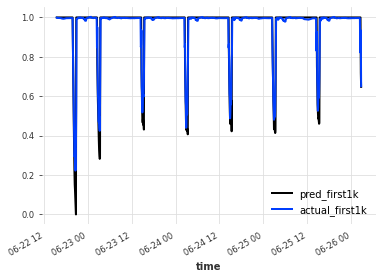

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 86.78it/s]


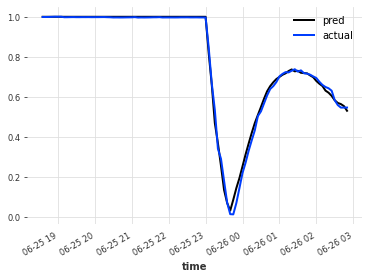

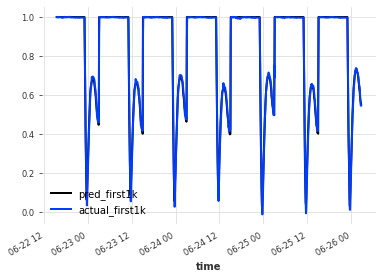

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 83.95it/s]


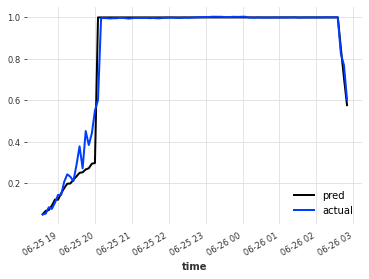

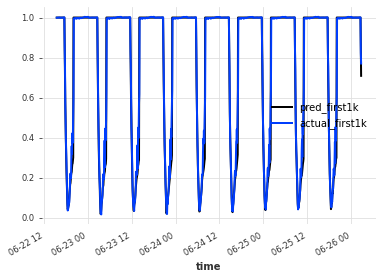

In [246]:
results_for_valid1, true_valid1, predict__valid1 = validate_model(model=model_all_pumps, 
                        validation_target=val_target1,
                        validation_cov=val_cov1)

1334 1334


100%|██████████| 801/801 [00:08<00:00, 91.55it/s]


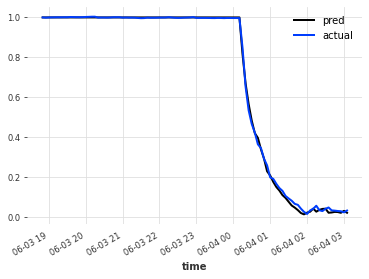

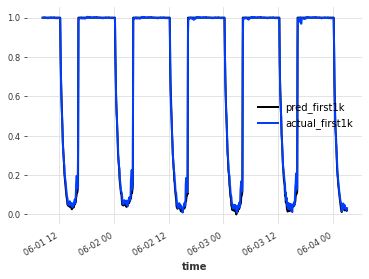

1334 1334


100%|██████████| 801/801 [00:08<00:00, 90.52it/s]


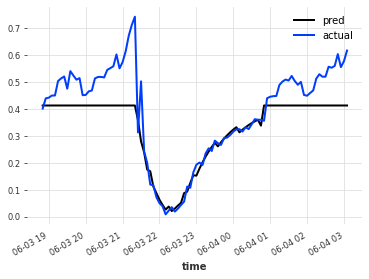

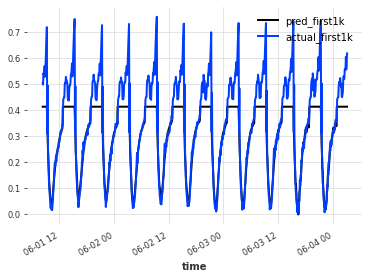

1334 1334


100%|██████████| 801/801 [00:08<00:00, 91.65it/s]


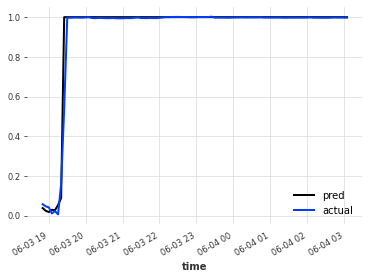

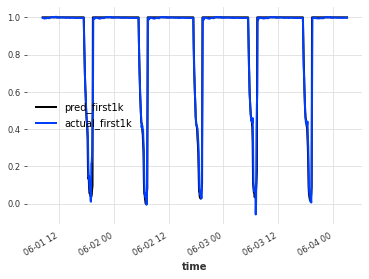

1334 1334


100%|██████████| 801/801 [00:08<00:00, 90.29it/s]


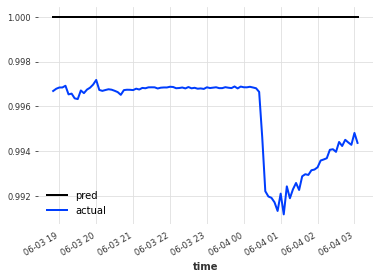

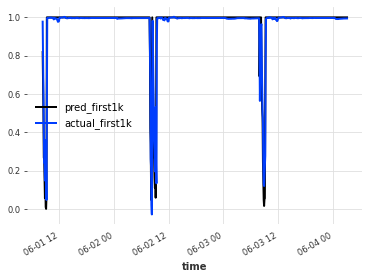

1334 1334


100%|██████████| 801/801 [00:09<00:00, 86.96it/s]


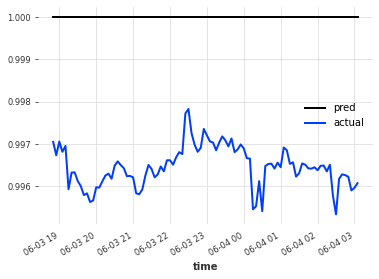

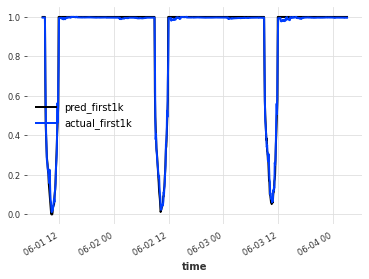

1334 1334


100%|██████████| 801/801 [00:09<00:00, 85.92it/s]


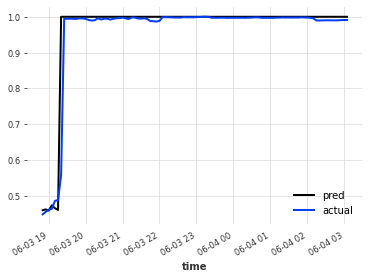

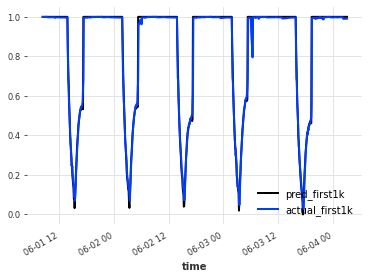

1334 1334


100%|██████████| 801/801 [00:09<00:00, 88.21it/s]


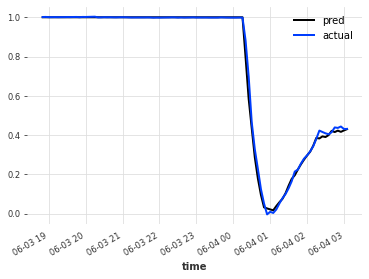

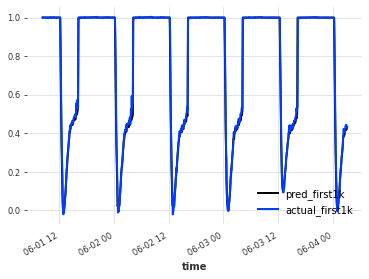

1334 1334


100%|██████████| 801/801 [00:09<00:00, 88.11it/s]


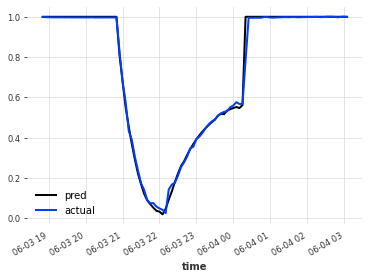

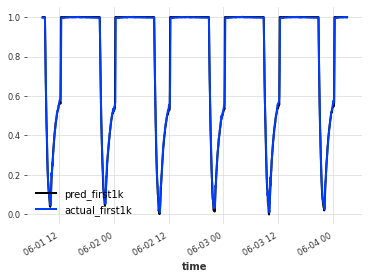

1334 1334


100%|██████████| 801/801 [00:09<00:00, 88.17it/s]


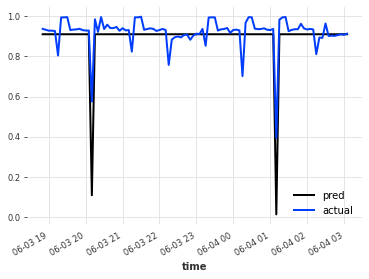

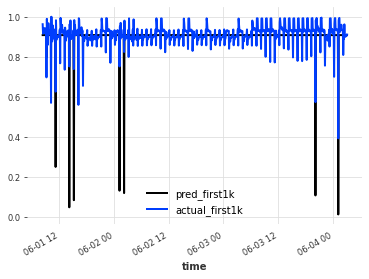

1334 1334


100%|██████████| 801/801 [00:09<00:00, 88.37it/s]


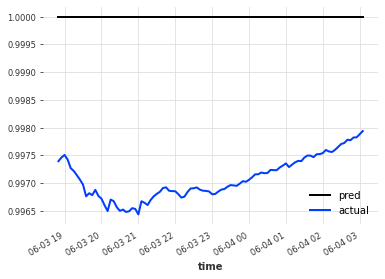

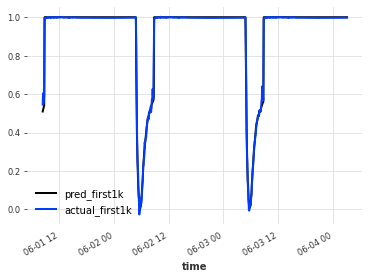

1334 1334


100%|██████████| 801/801 [00:09<00:00, 86.49it/s]


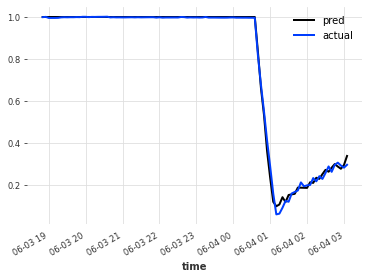

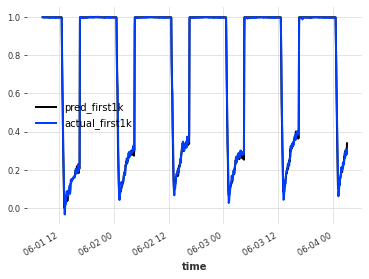

1334 1334


100%|██████████| 801/801 [00:09<00:00, 84.85it/s]


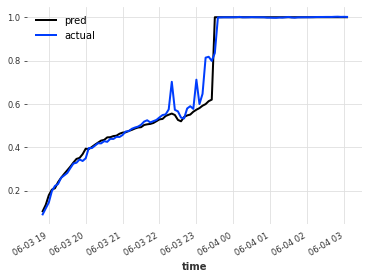

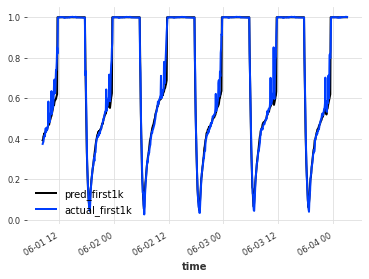

1334 1334


100%|██████████| 801/801 [00:09<00:00, 86.30it/s]


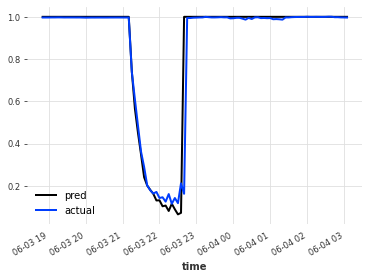

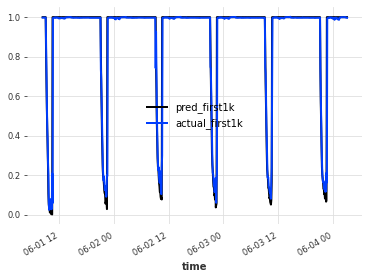

1334 1334


100%|██████████| 801/801 [00:09<00:00, 85.09it/s]


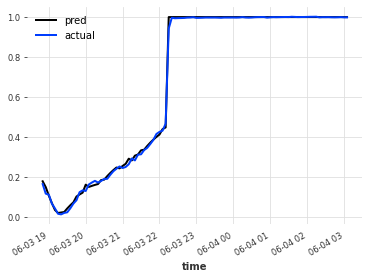

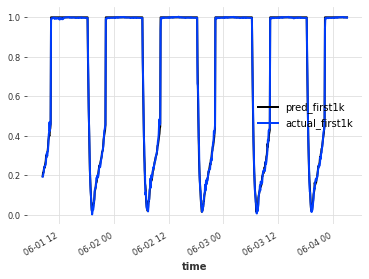

1334 1334


100%|██████████| 801/801 [00:09<00:00, 84.07it/s]


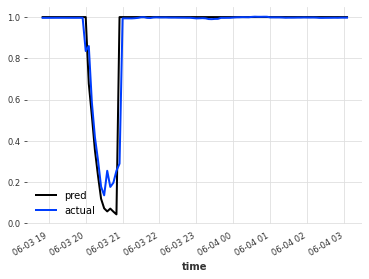

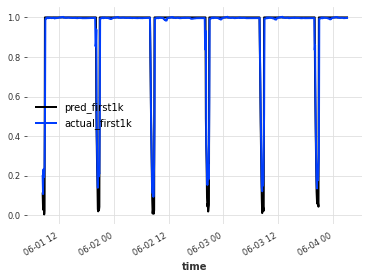

1334 1334


100%|██████████| 801/801 [00:09<00:00, 84.26it/s]


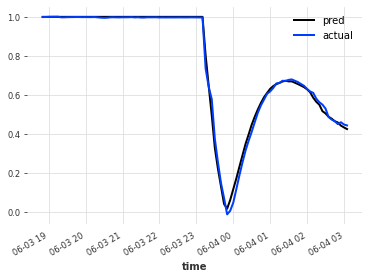

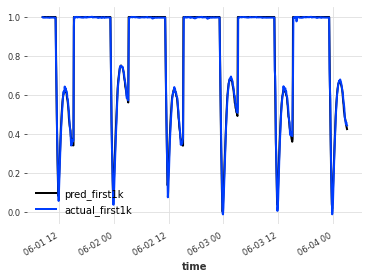

1334 1334


100%|██████████| 801/801 [00:09<00:00, 86.00it/s]


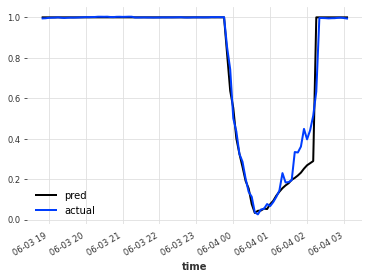

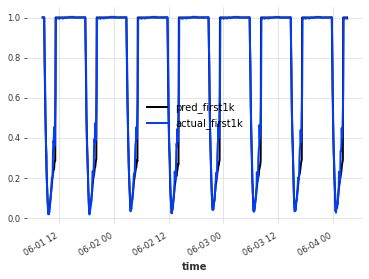

In [247]:
results_for_valid2, true_valid2, predict__valid2 = validate_model(model=model_all_pumps, 
                        validation_target=val_target2,
                        validation_cov=val_cov2)

In [248]:
valid_tcn = {'Valid1':{'true':true_valid1, 
                      'prediction':predict__valid1}, 
             'Valid2':{'true':true_valid2, 
                      'prediction':predict__valid2}}

In [251]:
validtcn_results = score_model(valid_tcn)
validtcn_results.loc['mean_tcn_valid'] = validtcn_results.mean()

validtcn_results.to_csv('tcn_valid_results.csv') 
validtcn_results

,mape,smape,mae,r2_value
Valid1,1.857333e+11,0.043622,0.012437,0.978408
Valid2,1.445451e+11,0.056359,0.015394,0.978116
mean_tcn_valid,1.651392e+11,0.049991,0.013915,0.978262


# transformers

In [253]:
from darts.models import TransformerModel


In [257]:
trans_model = TransformerModel(
    input_chunk_length = 10,
    output_chunk_length = 1,
    batch_size = 32,
    n_epochs = EPOCH,
    model_name = 'all_pumps_transformer',
    log_tensorboard=True,
    nr_epochs_val_period = 10,
    d_model = 32,
    nhead = 16,
    num_encoder_layers = 3,
    num_decoder_layers = 3,
    dim_feedforward = 512,
    dropout = 0.1,
    activation = "relu",
    random_state=0
)

In [258]:
trans_model.fit(series=train_target_v3,
              past_covariates=train_cov_v3,
              val_series=val_target_v3,
              val_past_covariates=val_cov_v3,
              verbose=True)

  0%|          | 0/5 [01:34<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
trans_model.save_model('allpumps_transformer.pth.tar')

In [ ]:
results_for_valid1trans, true_valid1trans, predict__valid1trans = validate_model(model=trans_model, 
                        validation_target=val_target1,
                        validation_cov=val_cov1)

In [ ]:
results_for_valid2trans, true_valid2trans, predict__valid2trans = validate_model(model=trans_model, 
                        validation_target=val_target2,
                        validation_cov=val_cov2)

In [ ]:
valid_trans = {'Valid1':{'true':true_valid1trans, 
                      'prediction':predict__valid1trans}, 
             'Valid2':{'true':true_valid2trans, 
                      'prediction':predict__valid2trans}}

In [ ]:
validtrans_results = score_model(valid_trans)
validtrans_results.loc['mean_transformers_valid'] = validtrans_results.mean()

validtrans_results.to_csv('transformers_valid_results.csv') 
validtrans_results

,mape,smape,mae,r2_value
Valid1,1.857333e+11,0.043622,0.012437,0.978408
Valid2,1.445451e+11,0.056359,0.015394,0.978116
mean_tcn_valid,1.651392e+11,0.049991,0.013915,0.978262
